In [ ]:
#source : https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import re
import tensorflow_addons as tfa
import keras

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import json
import shutil
import random

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.version.VERSION}')
print(f'Python V{sys.version}')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow V2.15.0
Keras V2.15.0
Python V3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# Plot Config

In [ ]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/TSL/

In [ ]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 111
IS_INTERACTIVE = False
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 32
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

# Split


In [ ]:
# # Load JSON file
# with open('sign_to_prediction_index_map.json', 'r', encoding='utf-8') as f:
#     label_map = json.load(f)

# def get_key_by_value(d, value):
#     return next((k for k, v in d.items() if v == value), None)

# # Define the paths
# for i in range(111):
#     key = get_key_by_value(label_map,i)
#     original_data_dir = f'preprocessed_parquet_withaugment/{key}'
#     train_val_dir = f'preprocessed_parquet-trainval/{key}'
#     test_dir = f'preprocessed_parquet-testset/{key}'

#     # Create directories if they don't exist
#     os.makedirs(train_val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     # Define the split ratio
#     test_split_ratio = 0.1

#     # Get list of all files in the original data directory
#     all_files = [os.path.join(original_data_dir, f) for f in os.listdir(original_data_dir) if os.path.isfile(os.path.join(original_data_dir, f))]

#     # Shuffle the files randomly
#     random.seed(42)  # For reproducibility
#     random.shuffle(all_files)

#     # Calculate the number of test files
#     num_test_files = int(len(all_files) * test_split_ratio)

#     # Split the files
#     test_files = all_files[:num_test_files]
#     train_val_files = all_files[num_test_files:]

#     # Move the files to the respective directories
#     for f in test_files:
#         shutil.move(f, os.path.join(test_dir, os.path.basename(f)))

#     for f in train_val_files:
#         shutil.move(f, os.path.join(train_val_dir, os.path.basename(f)))

#     print(f'Moved {len(test_files)} files to {test_dir}')
#     print(f'Moved {len(train_val_files)} files to {train_val_dir}')

In [ ]:
# # Directory containing the data folders
# data_dir = 'preprocessed_parquet-trainval'

# # List to store the data
# data_list = []

# # Walk through the directory structure
# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         if file.endswith('.parquet'):
#             # Construct the full file path
#             file_path = os.path.join(root, file)

#             # Remove the data_dir part from the file path
#             relative_path = os.path.relpath(file_path, data_dir)

#             # Extract the participant_id from the file name
#             participant_id = int(file.split('.')[0])

#             # Extract the sign from the directory name
#             sign = os.path.basename(root)

#             # Get the sequence_id from the mapping
#             sequence_id = label_map.get(sign, -1)  # Default to -1 if sign is not found

#             # Add the path, participant_id, sequence_id, and sign to each row in the DataFrame
#             data_entry = {
#                 "path": relative_path,
#                 "participant_id": participant_id,
#                 "sequence_id": sequence_id,
#                 "sign": sign
#             }

#             # Append to the data list
#             data_list.append(data_entry)

# # Create a DataFrame from the data list
# final_df = pd.DataFrame(data_list)

# # Save the DataFrame to a CSV file
# final_df.to_csv('train-fliptest.csv', index=False)

# print("CSV file has been created.")


# Utils

In [ ]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [ ]:
# Read Training Data
if IS_INTERACTIVE or not PREPROCESS_DATA:
    train = pd.read_csv('train-fliptest.csv')
else:
    train = pd.read_csv('train-fliptest.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5994


# Add File Path

In [ ]:
# Get complete file path to file
def get_file_path(path):
    return f'preprocessed_parquet-trainval\{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [ ]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [ ]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
0,สวัสดี/22.parquet,22,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/22.parquet,88
1,สวัสดี/5.parquet,5,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/5.parquet,88
2,สวัสดี/28.parquet,28,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/28.parquet,88
3,สวัสดี/16.parquet,16,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/16.parquet,88
4,สวัสดี/21.parquet,21,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/21.parquet,88
5,สวัสดี/27.parquet,27,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/27.parquet,88
6,สวัสดี/17.parquet,17,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/17.parquet,88
7,สวัสดี/11.parquet,11,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/11.parquet,88
8,สวัสดี/26.parquet,26,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/26.parquet,88
9,สวัสดี/25.parquet,25,0,สวัสดี,preprocessed_parquet-trainval\สวัสดี/25.parquet,88


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5994 non-null   object
 1   participant_id  5994 non-null   int64 
 2   sequence_id     5994 non-null   int64 
 3   sign            5994 non-null   object
 4   file_path       5994 non-null   object
 5   sign_ord        5994 non-null   int8  
dtypes: int64(2), int8(1), object(3)
memory usage: 240.1+ KB


None

# Video Statistics

In [ ]:
N = int(1e3) if (IS_INTERACTIVE or not PREPROCESS_DATA) else int(len(train['file_path']))
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, replace=False, random_state=SEED))):
    file_path = file_path.replace('\\', '/')
    full_path = os.path.join('/content/drive/My Drive/TSL',file_path)
    df = pd.read_parquet(full_path)
    df['frame'] = df['frame'].apply(lambda x: int(re.search(r'\d+', x).group()))
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()


  0%|          | 0/1000 [00:00<?, ?it/s]

,N_UNIQUE_FRAMES
count,1000.0
mean,30.0
std,0.0
min,30.0
1%,30.0
5%,30.0
25%,30.0
50%,30.0
75%,30.0
95%,30.0


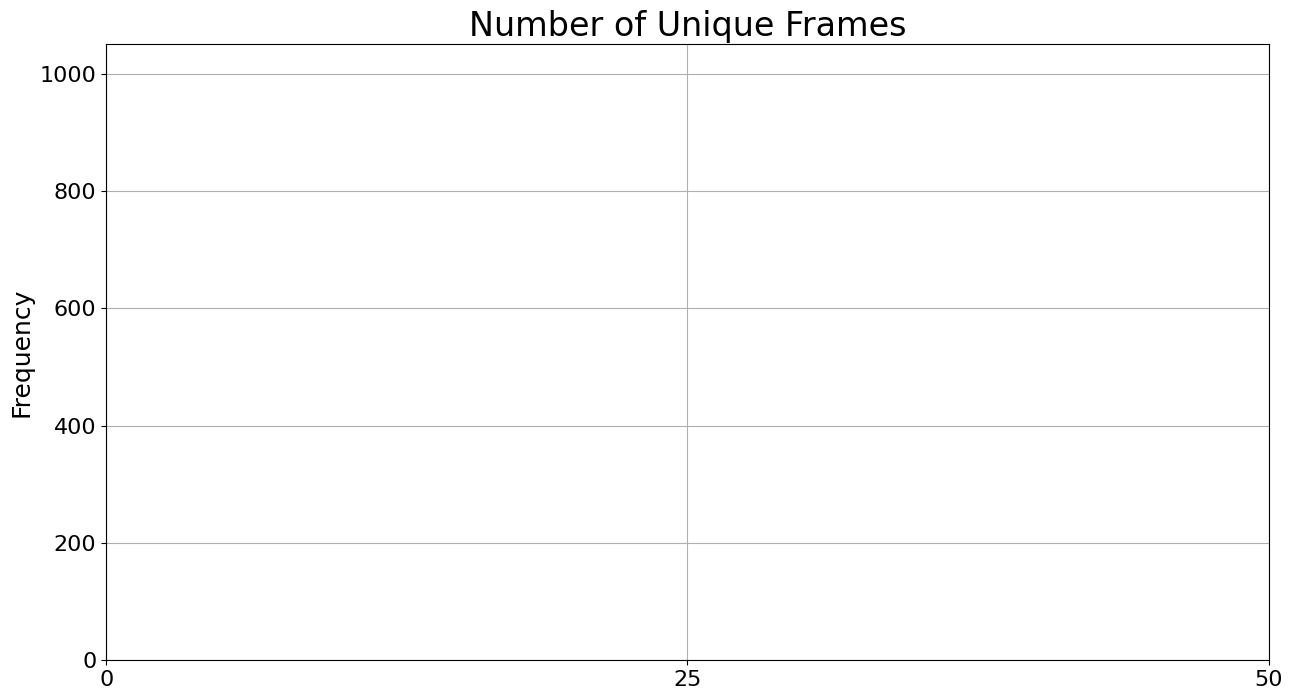

In [ ]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.0
mean,0.0
std,0.0
min,0.0
1%,0.0
5%,0.0
25%,0.0
50%,0.0
75%,0.0
95%,0.0


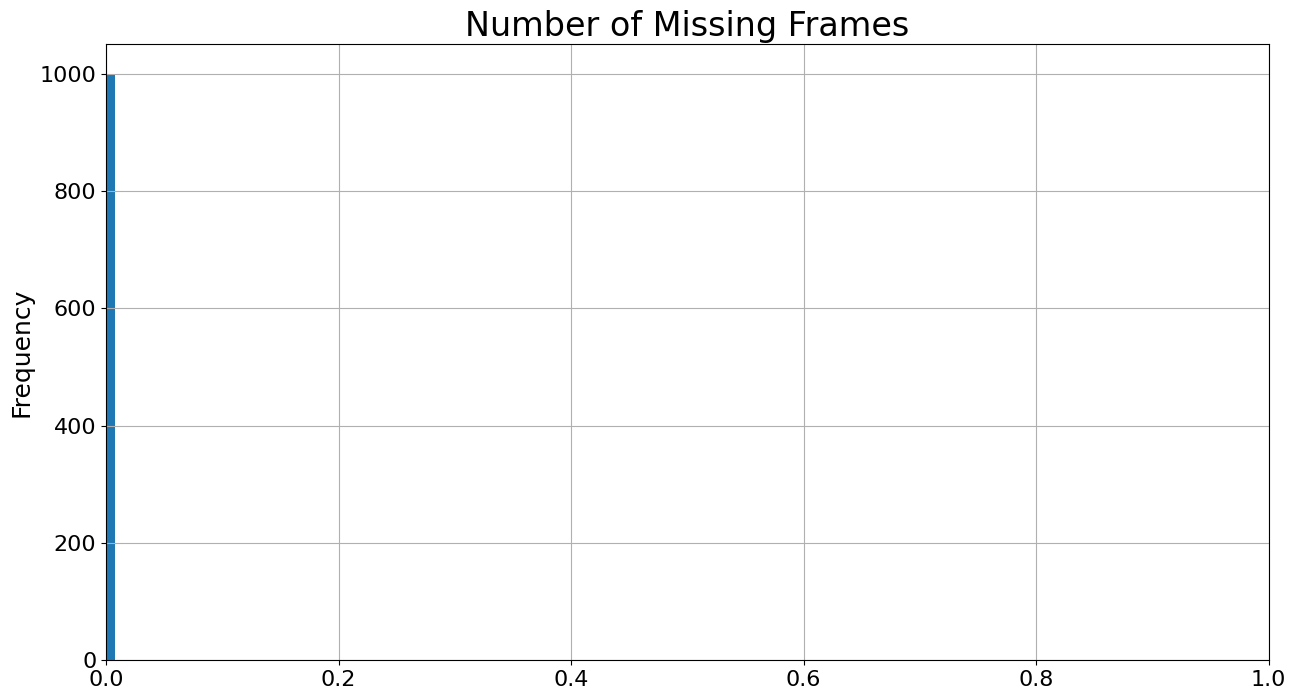

In [ ]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.0
mean,29.0
std,0.0
min,29.0
1%,29.0
5%,29.0
25%,29.0
50%,29.0
75%,29.0
95%,29.0


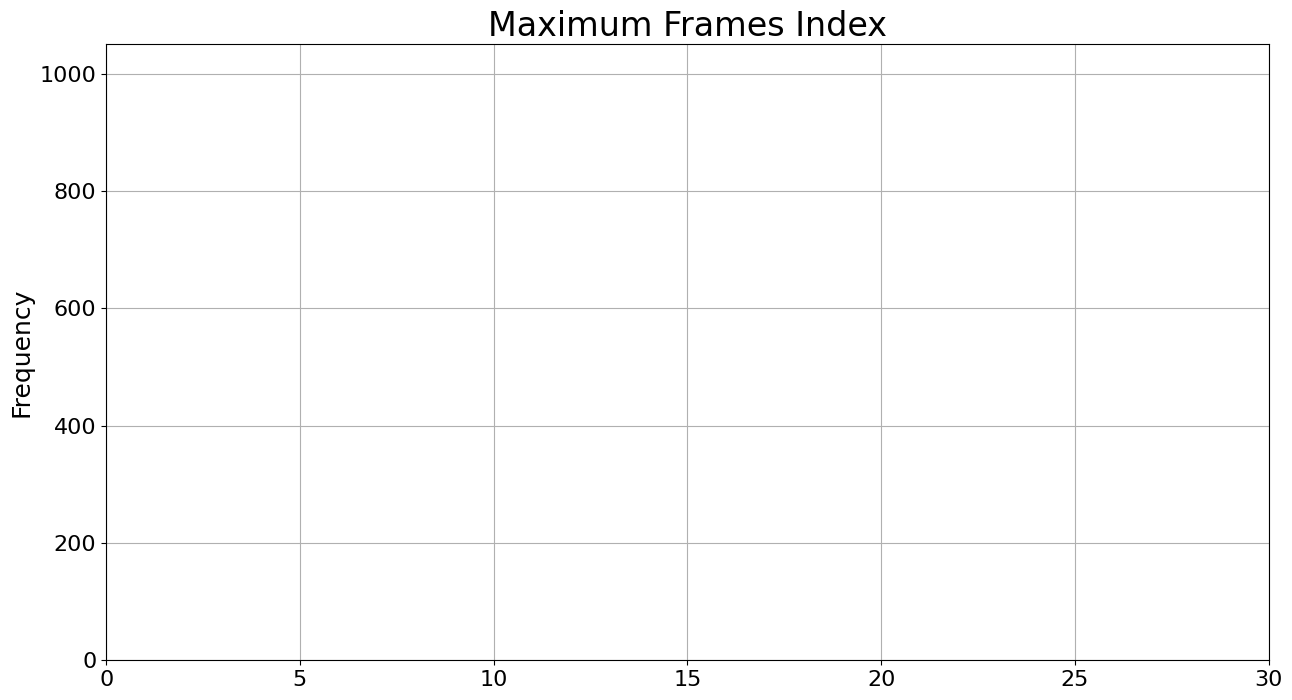

In [ ]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices

In [ ]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [ ]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Process Data Tensorflow

In [ ]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
"""
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]

        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum

        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )

        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)

        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)

        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]

        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )

        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)

            return data, non_empty_frames_idxs

preprocess_layer = PreprocessLayer()

# Interpolate NaN Values

In [ ]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544

"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)

    return data

# Create Dataset

In [ ]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        file_path = file_path.replace('\\', '/')
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [ ]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = 'dataset'

# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

X_train shape: (5402, 64, 66, 3), dtype: float32
y_train shape: (5402,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (5402, 64), dtype: float32
X_val shape: (592, 64, 66, 3), dtype: float32
y_val shape: (592,), dtype: int32
NON_EMPTY_FRAME_IDXS_VAL shape: (592, 64), dtype: float32
# NaN Values X_train: 0


In [ ]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
73,50
36,50
80,50
44,50
107,50
68,48
70,48
3,48
88,48
26,48


# Number Of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

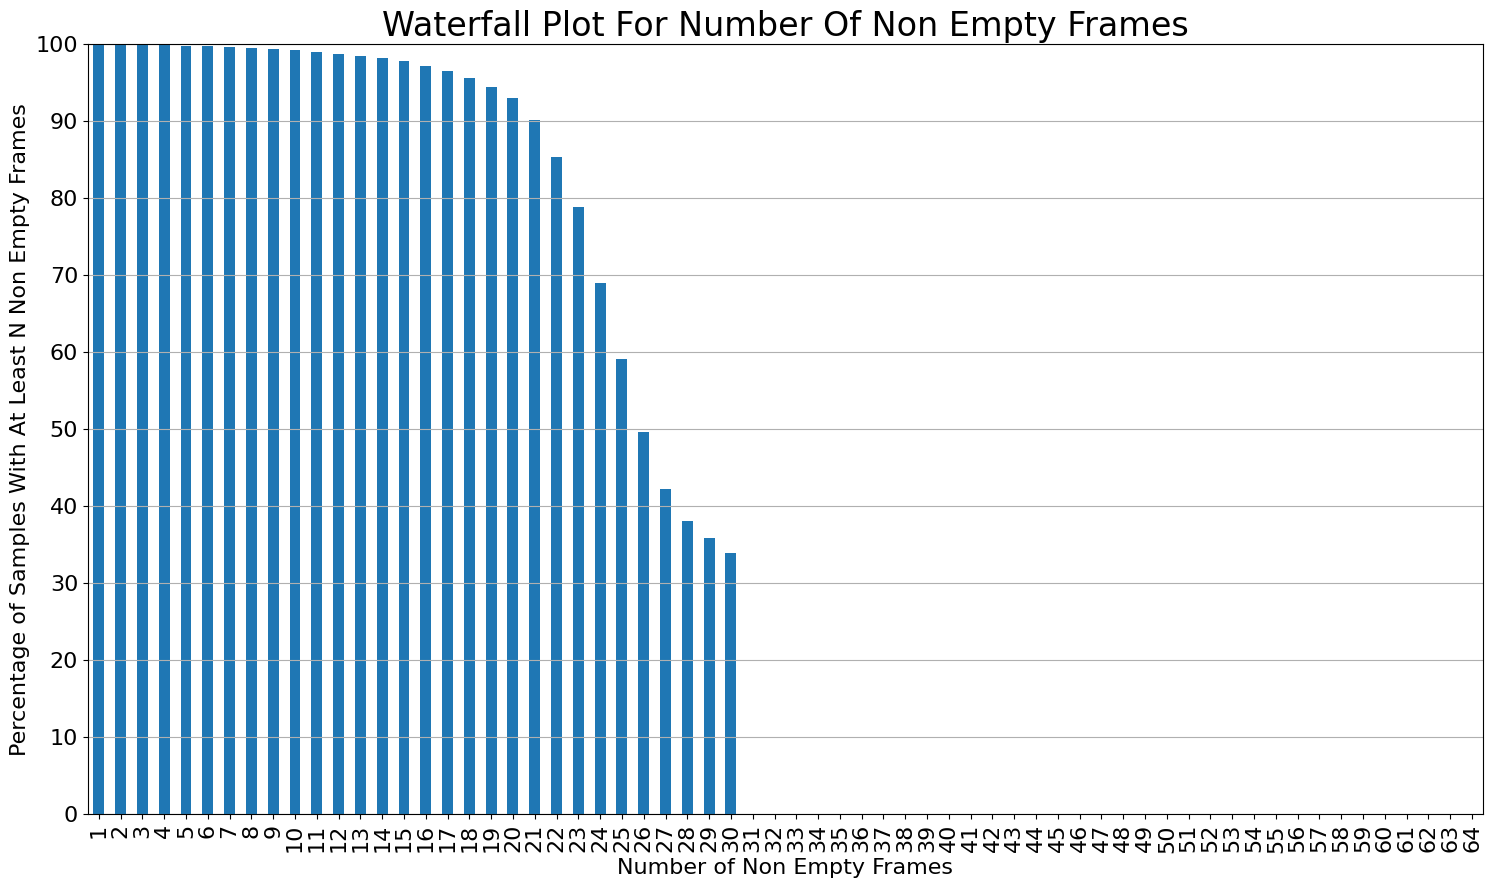

In [ ]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1)
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

# Percentage of Frames Filled

In [ ]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 39.81%


# Feature Statistics - Lips

In [ ]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.88%


  0%|          | 0/40 [00:00<?, ?it/s]

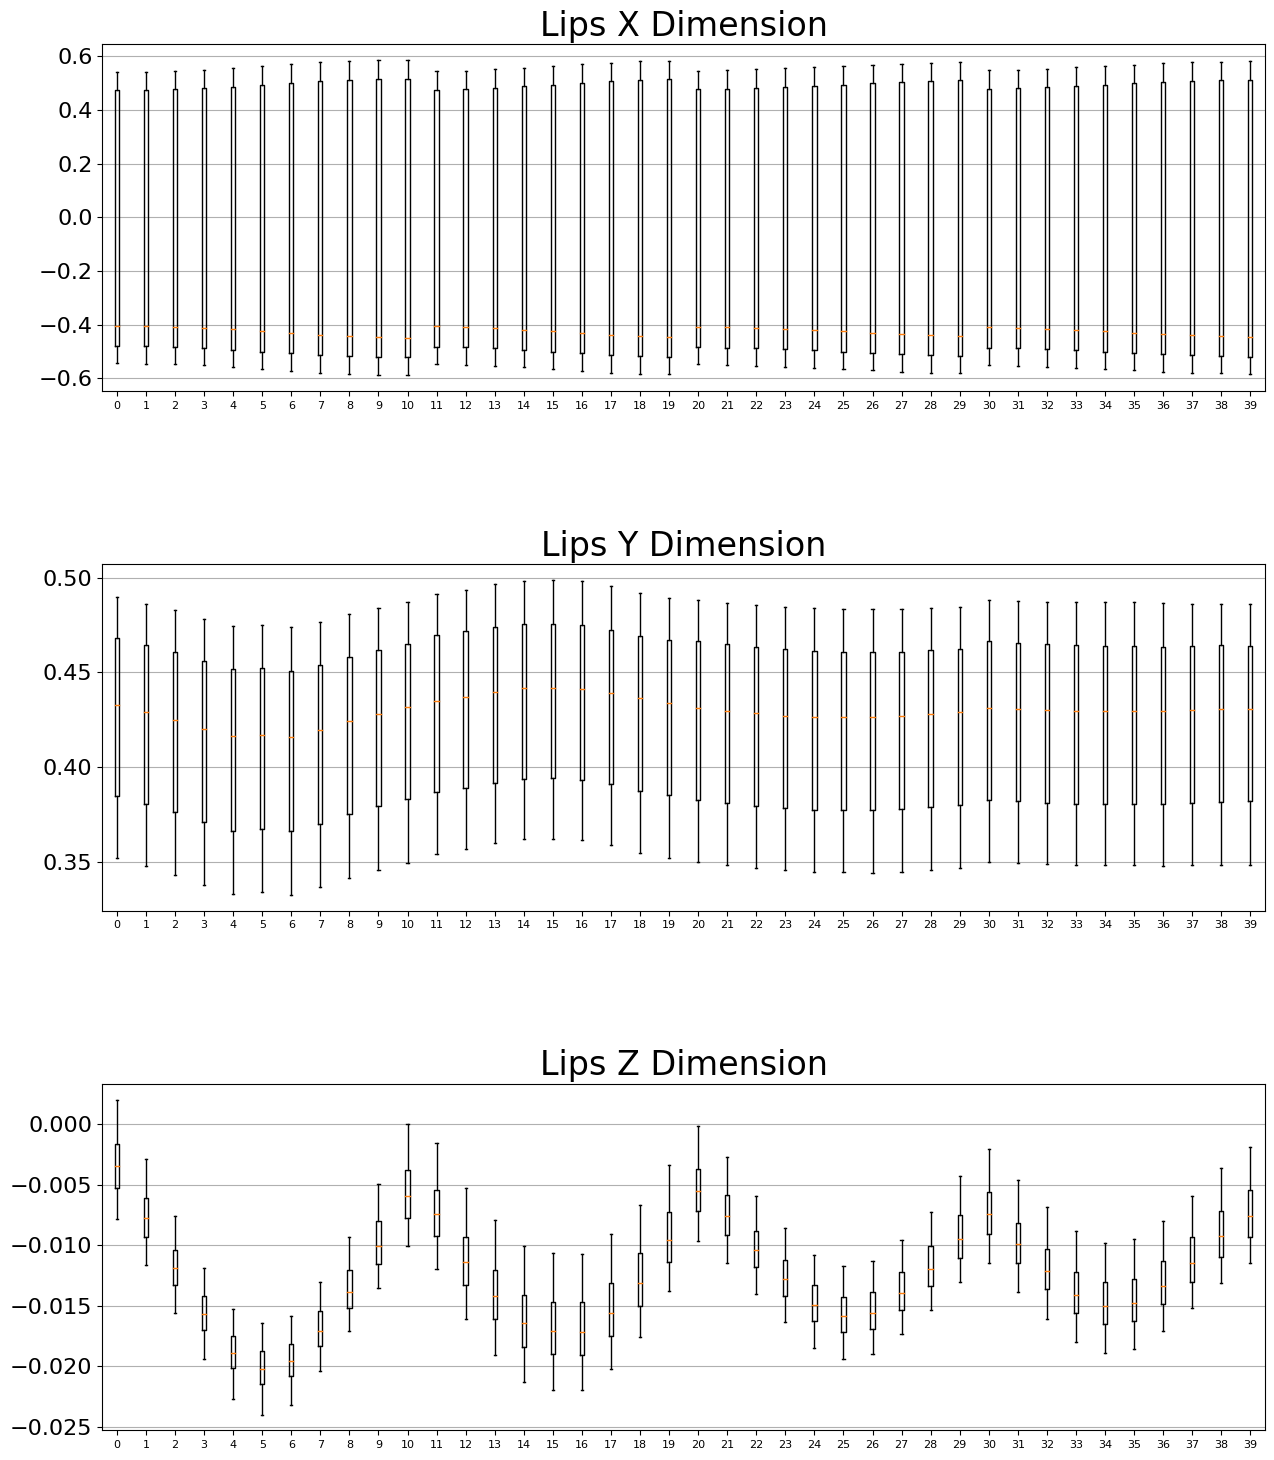

In [ ]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [ ]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

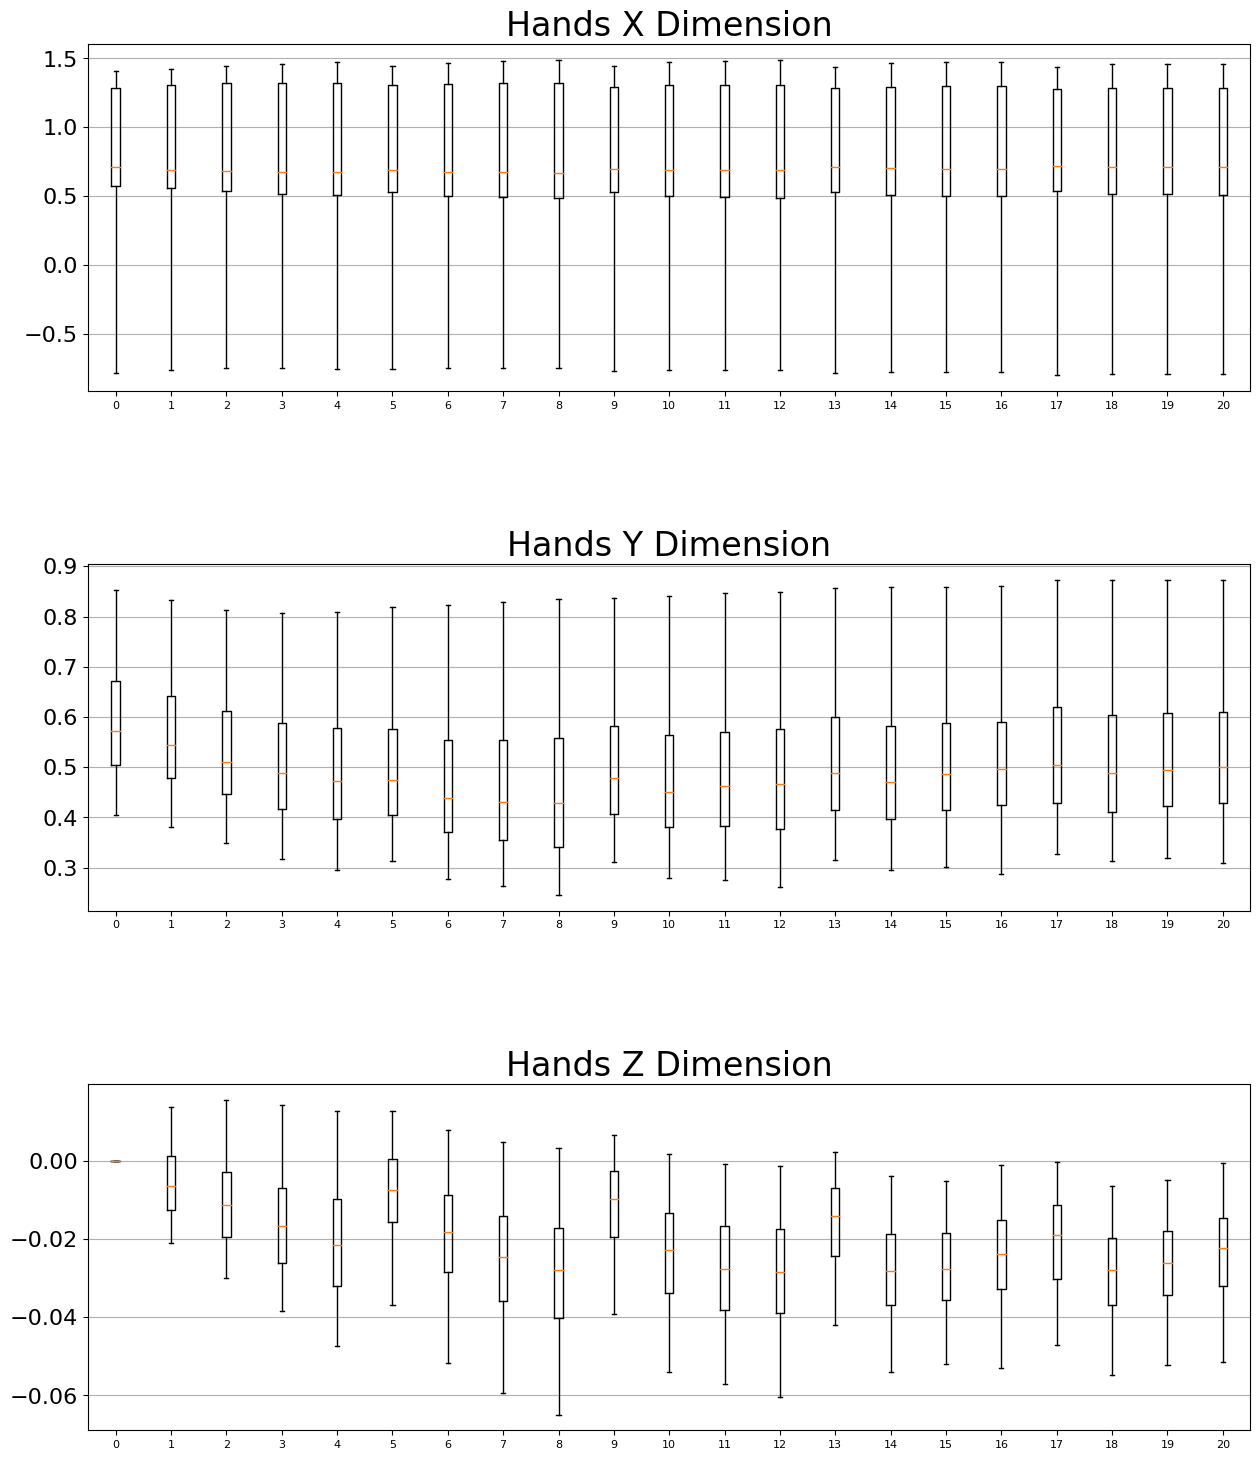

In [ ]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T

    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [ ]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

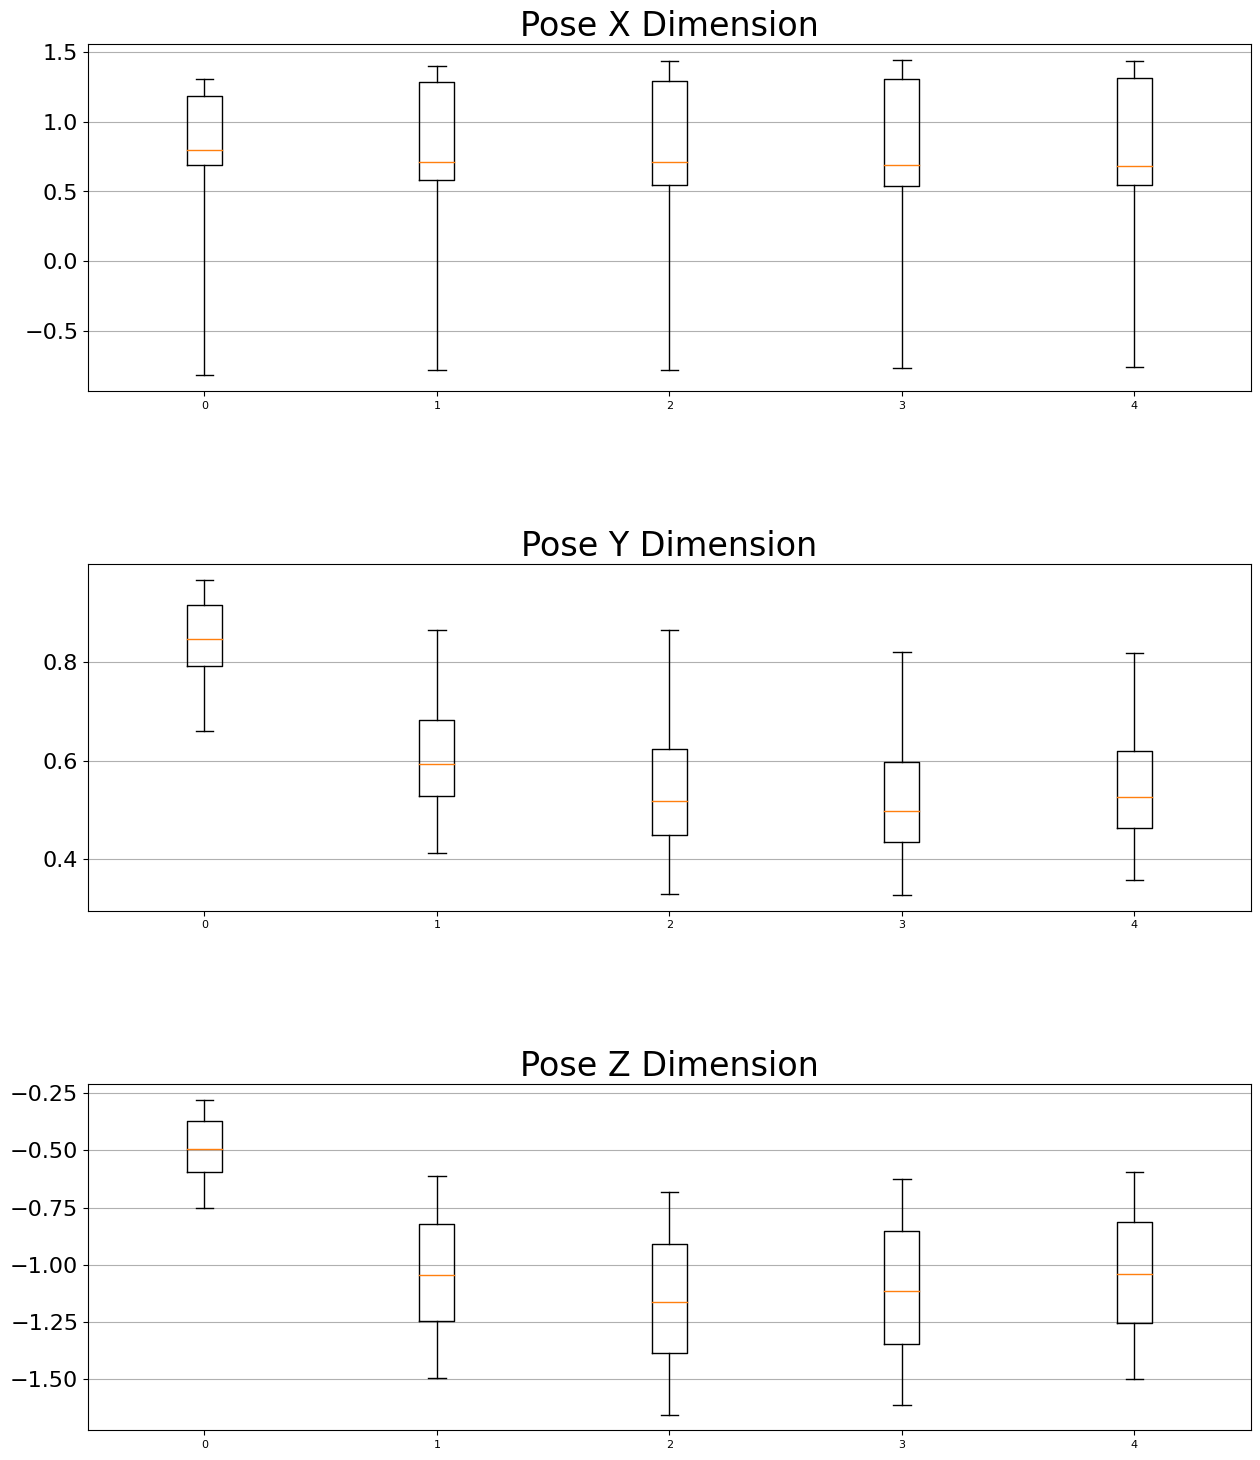

In [ ]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Samples

In [ ]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]

        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [ ]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (444, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (444, 64), dtype: float32
y_batch shape: (444,), dtype: int64


,Counts
110,4
0,4
1,4
2,4
3,4
...,...
10,4
11,4
12,4
13,4


# Model Config

In [ ]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [ ]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [ ]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x

# Landmark Embedding

In [ ]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [ ]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

# Augmentation

In [ ]:
# Not used, adds random X/y translation to input on samples level
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std

    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )

    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)

        return lips0, left_hand0, pose0

# Sparse Categorical Crossentropy With Label Smoothing

In [ ]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [ ]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )


    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])

    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)

    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls

    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [ ]:
tf.keras.backend.clear_session()

model = get_model()

In [ ]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 64)                   0         ['tf.math.not_equal[0][0]']   
                                                                                              

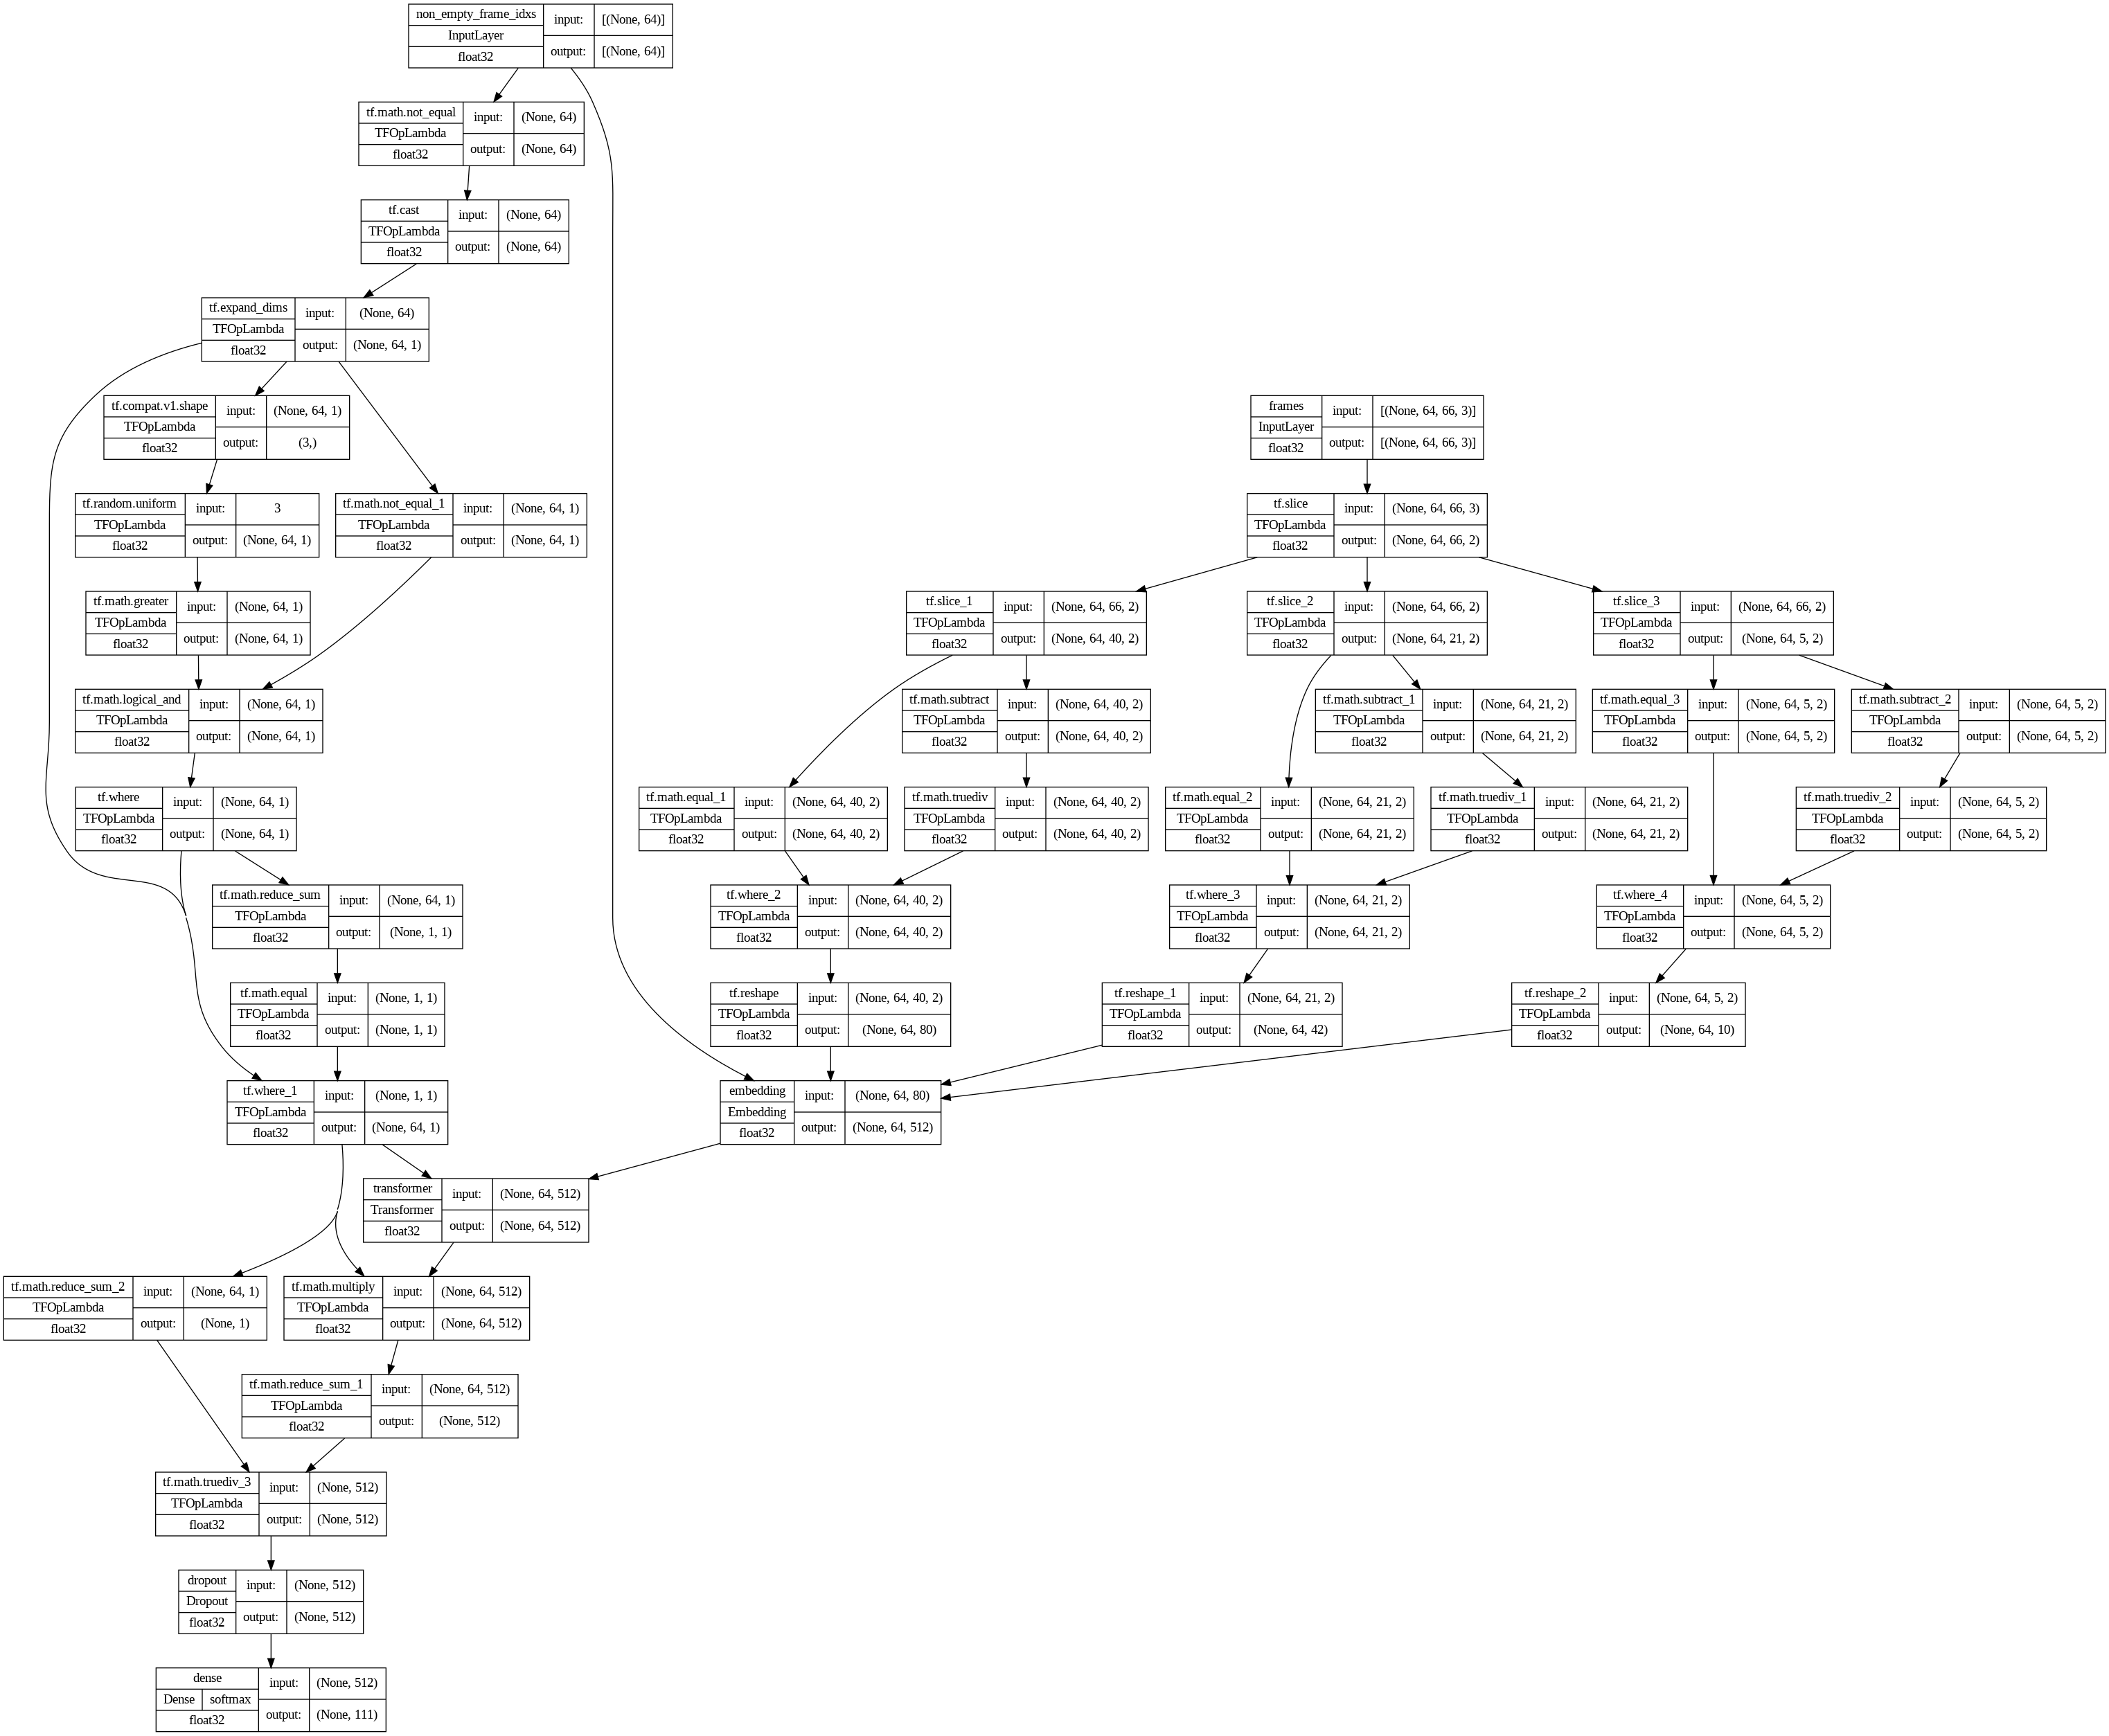

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# No NaN Predictions

In [ ]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    y_pred = model.predict_on_batch(X_batch).flatten()

    print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# NaN Values In Prediction: 0


# Weight Initialization

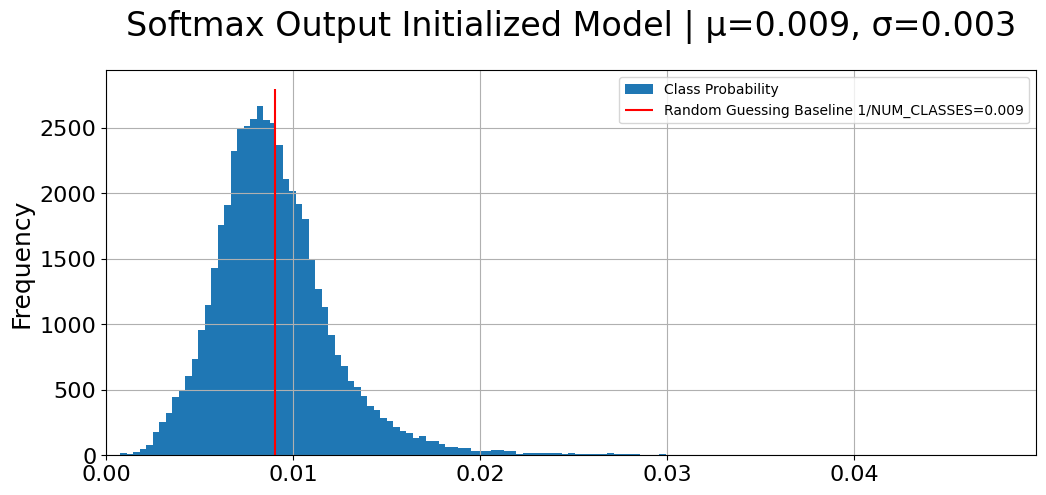

In [ ]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [ ]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

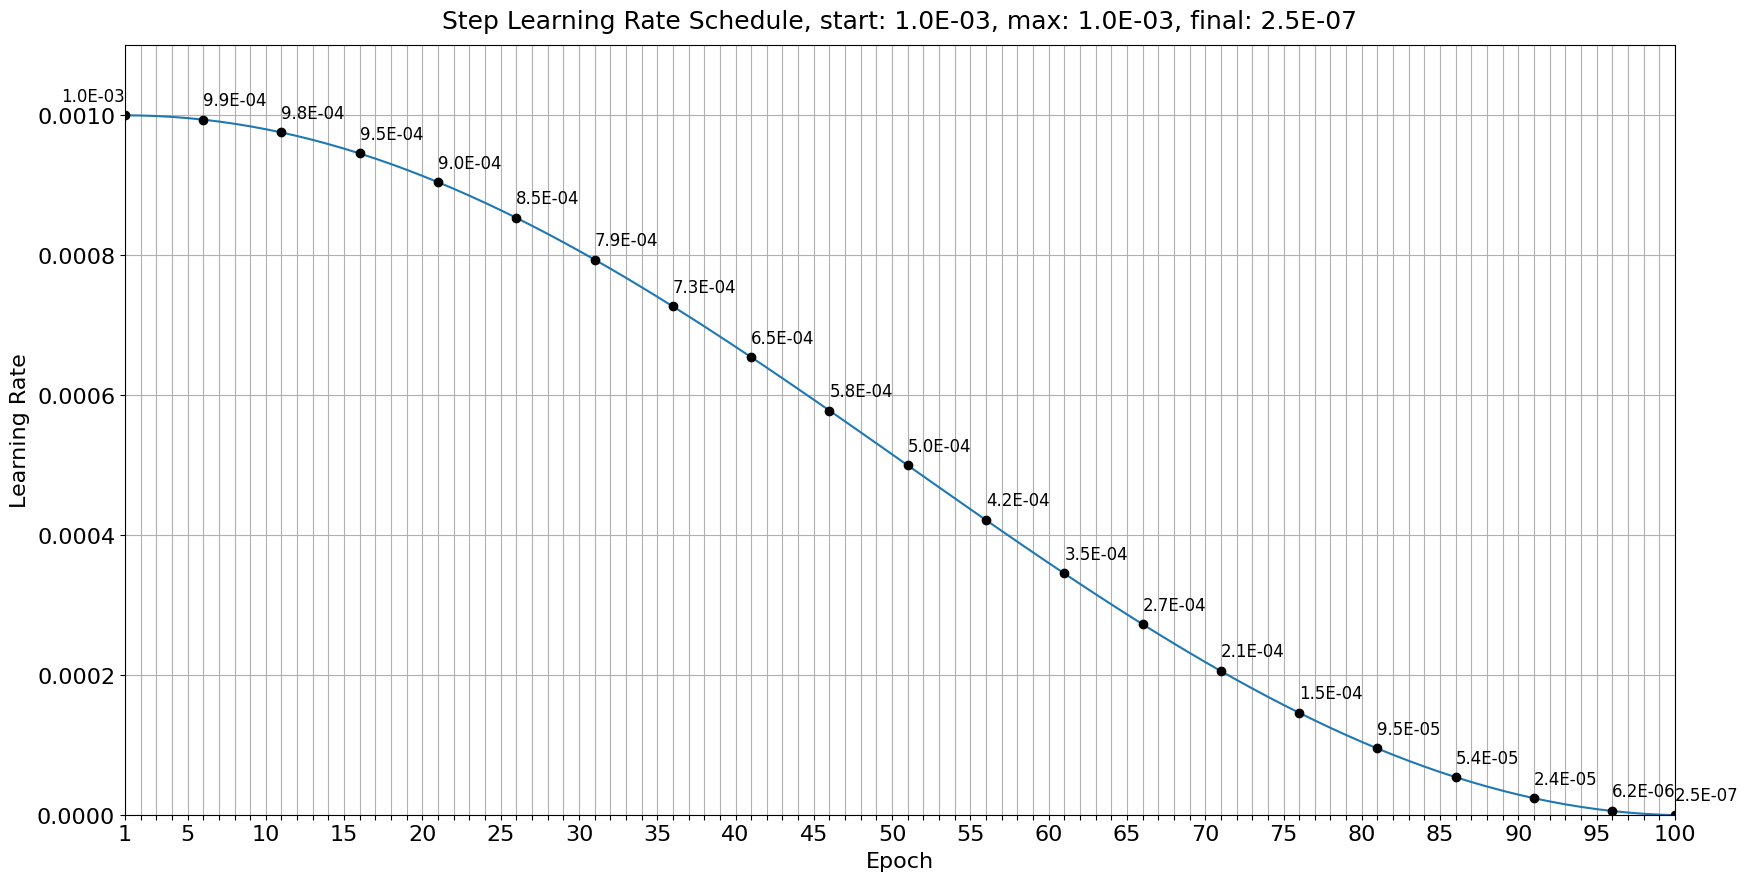

In [ ]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Callback

In [ ]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [ ]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
    pass

19.4 ms ± 5.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [ ]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Unique Signs in Validation Set: 111


,Count
26,6
88,6
101,6
73,4
6,4
36,4


# Evaluate Initialzied Model

In [ ]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

19/19 - 2s - loss: 4.7518 - acc: 0.0152 - top_5_acc: 0.0676 - top_10_acc: 0.0861 - 2s/epoch - 121ms/step


# Train

In [ ]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 64)                   0         ['tf.math.not_equal[0][0]']   
                                                                                              

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save Model Weights
model.save_weights('model_weight.h5')

In [ ]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    # labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]
    labels = [ORD2SIGN.get(i) for i in range(NUM_CLASSES)]

19/19 - 2s - 2s/epoch - 107ms/step


# Landmark Attention Weights

In [ ]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 31.2%
left_hand_embedding weight: 35.6%
pose_embedding weight: 33.2%


# Classification Report

In [ ]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [ ]:
if USE_VAL:
    print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
ไพบูลย์ นิติตะวัน,1.00,1.00,1.00,6,ไพบูลย์ นิติตะวัน,110
ก,1.00,1.00,1.00,5,ก,0
กรณ์ จาติกวณิช,1.00,1.00,1.00,6,กรณ์ จาติกวณิช,1
กระโดด,1.00,1.00,1.00,4,กระโดด,2
กลับ,1.00,1.00,1.00,6,กลับ,3
ข,1.00,1.00,1.00,5,ข,4
ขนม,1.00,1.00,1.00,6,ขนม,5
อนุทิน ชาญวีรกูล,1.00,1.00,1.00,6,อนุทิน ชาญวีรกูล,95
อยู่,1.00,1.00,1.00,6,อยู่,96
อะไร,1.00,1.00,1.00,6,อะไร,97


# Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

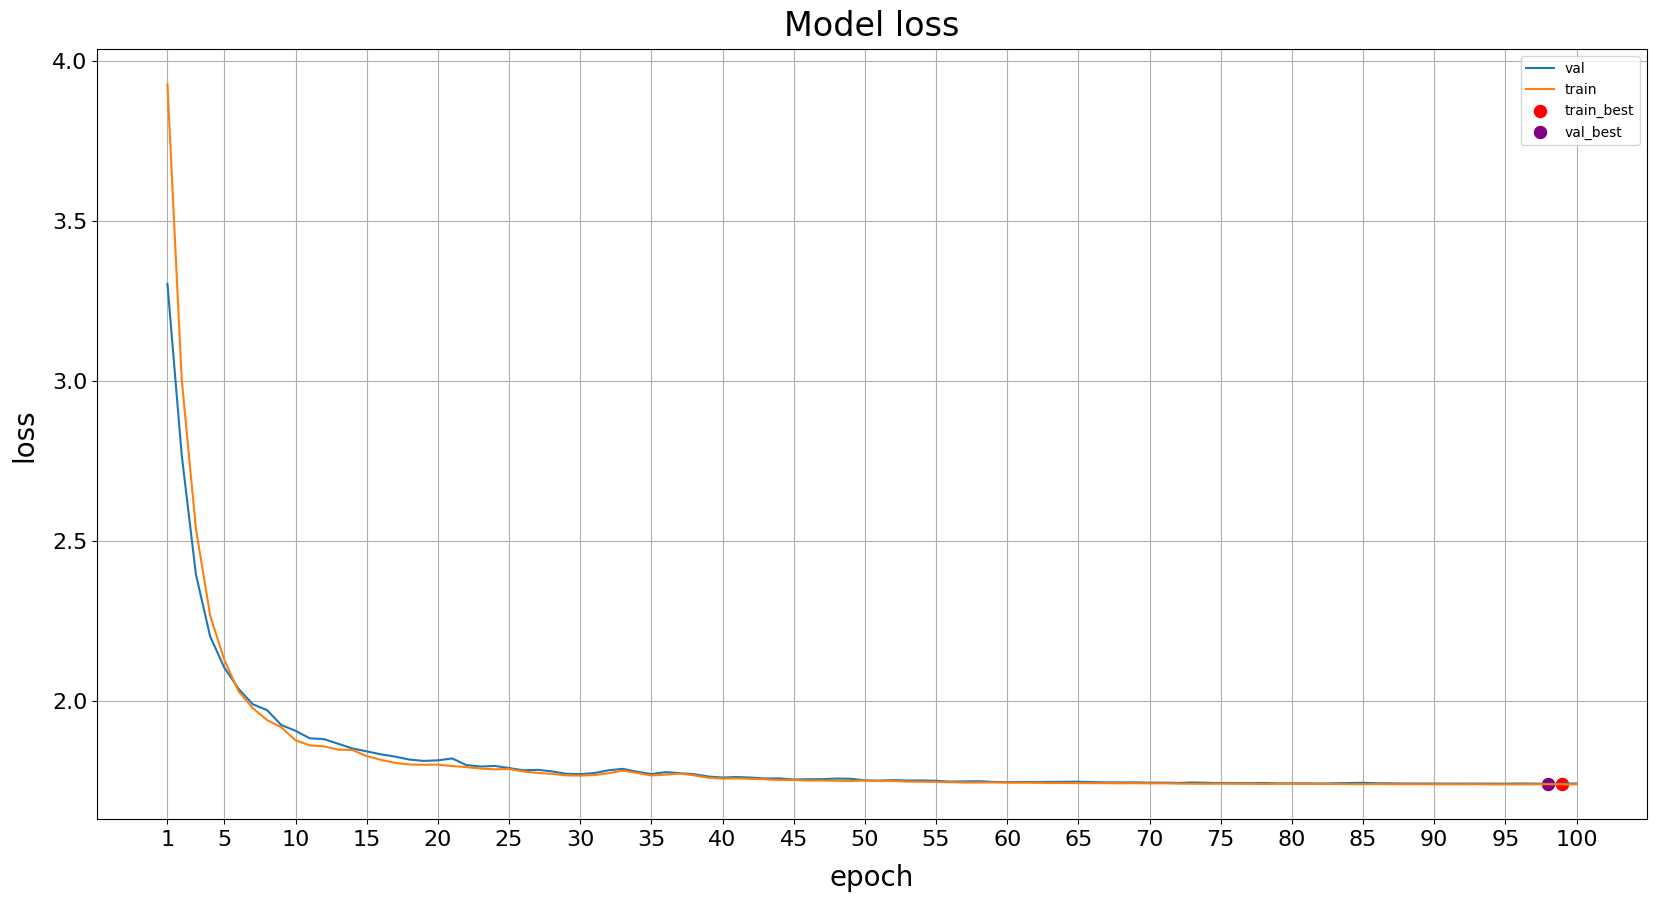

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

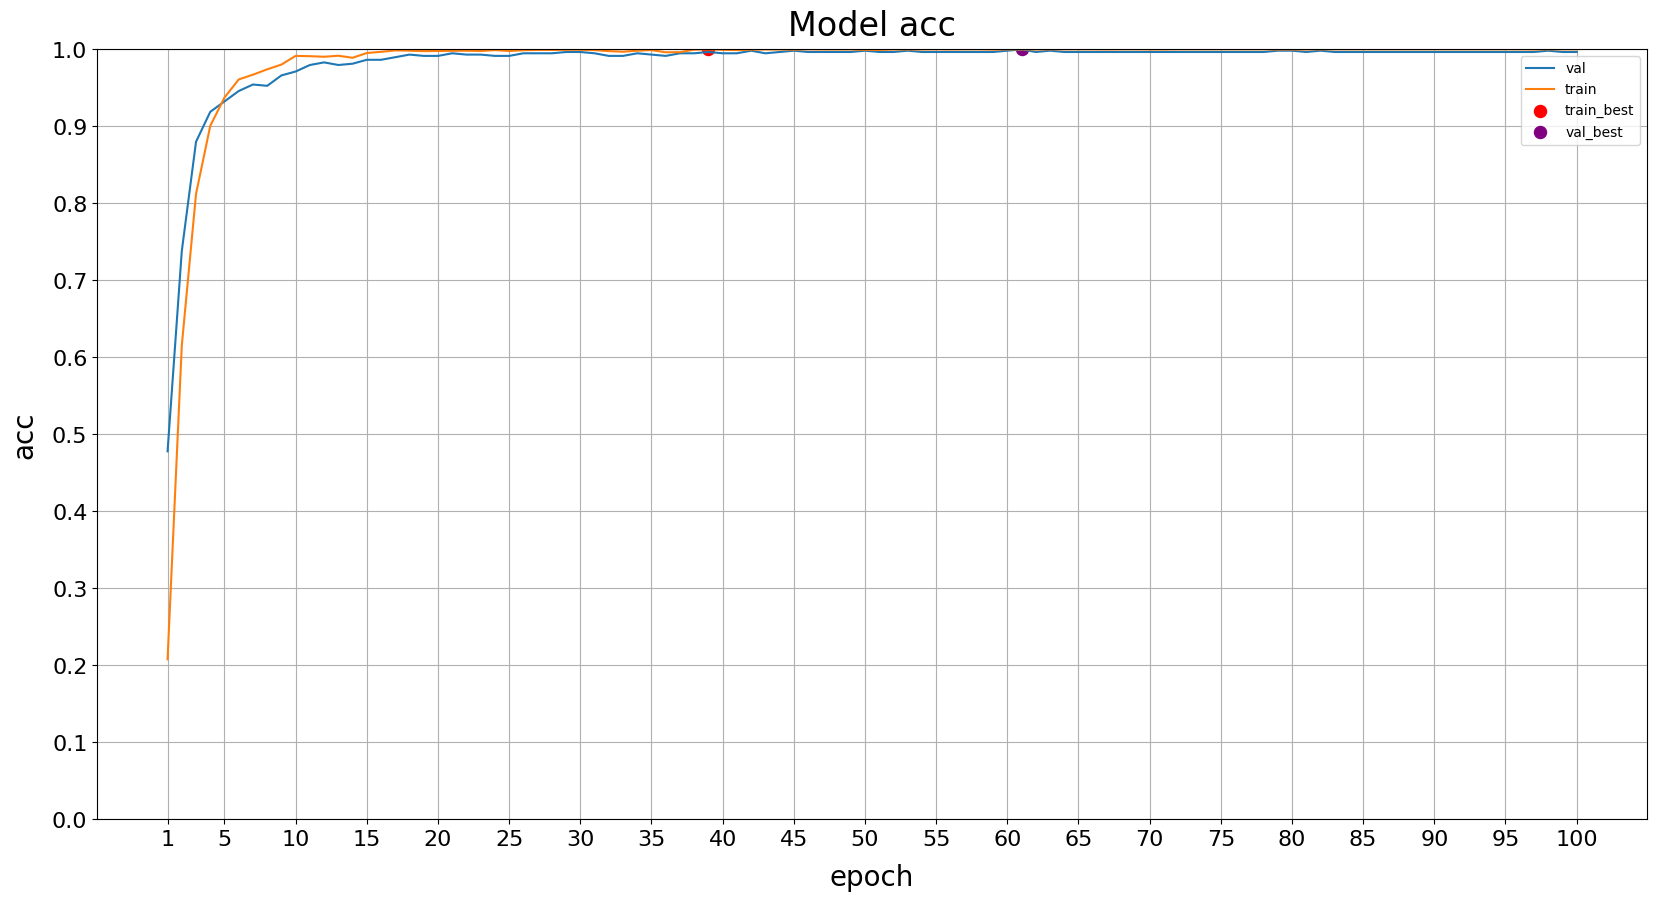

In [ ]:
if TRAIN_MODEL:
  plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

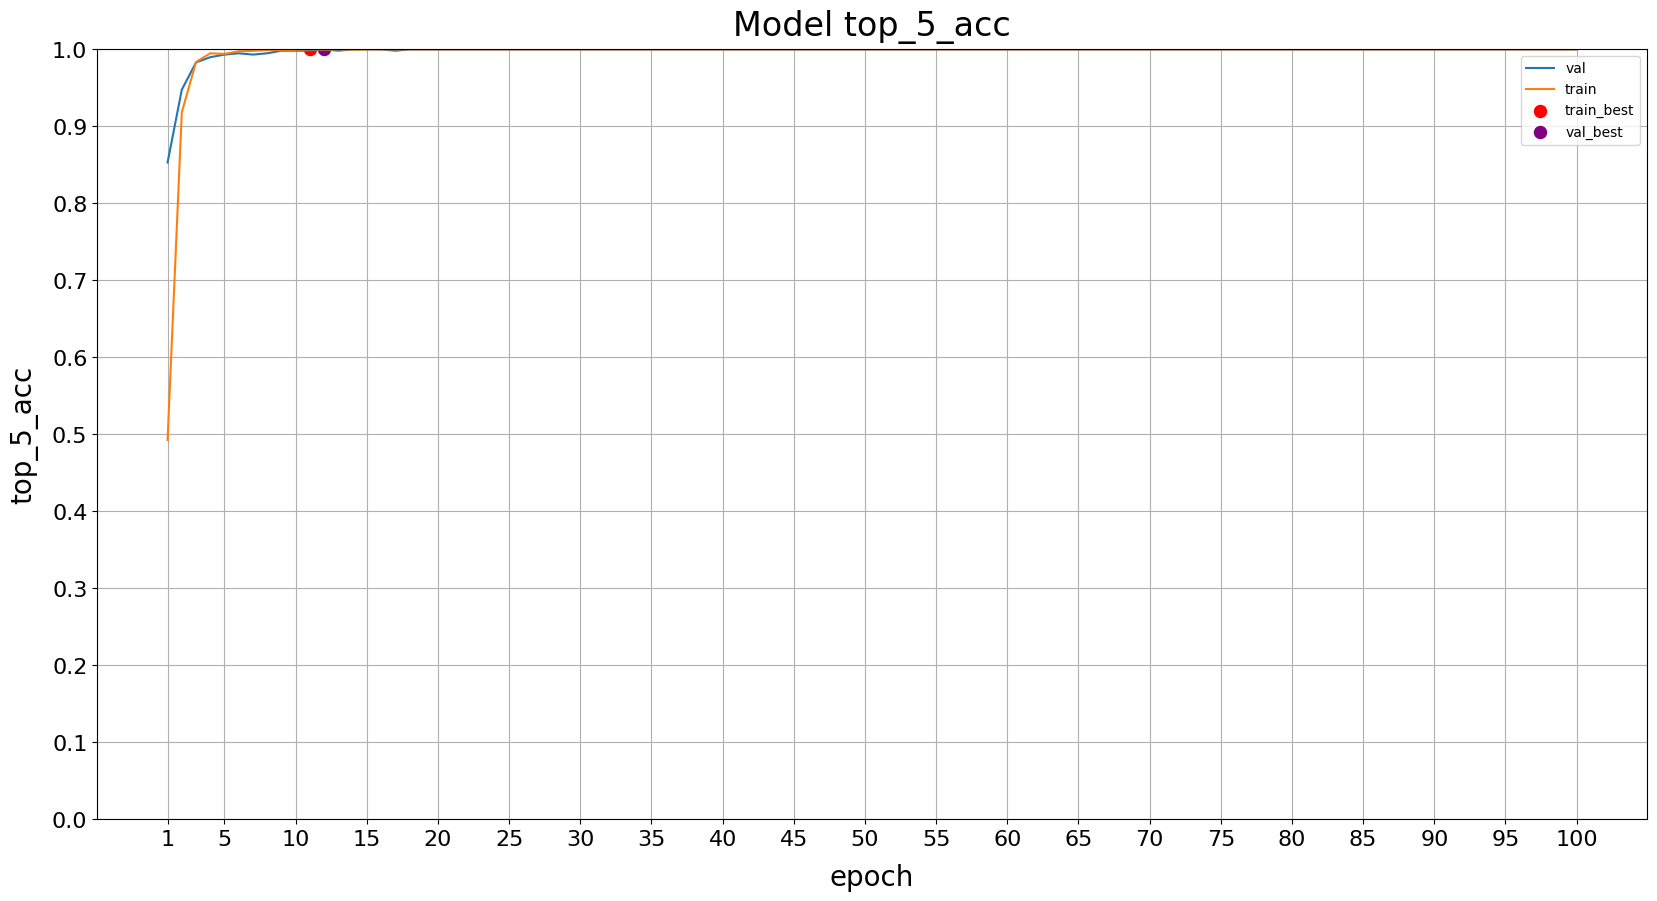

In [ ]:
if TRAIN_MODEL:
      plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

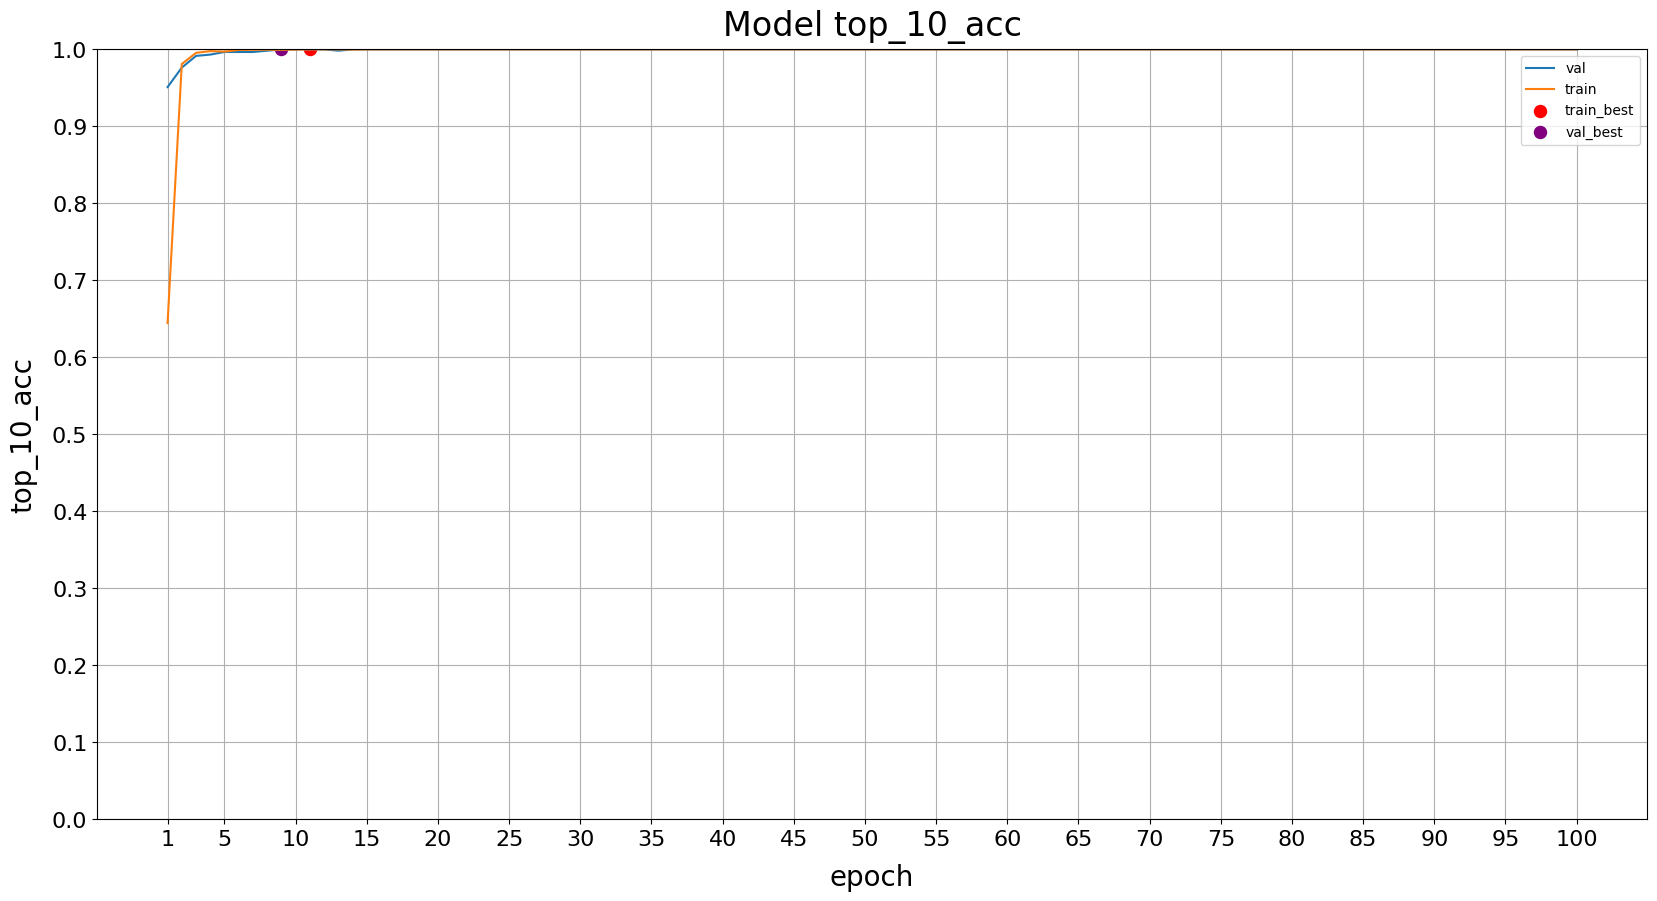

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [ ]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
#demo_raw_data = load_relevant_data_subset('content\\drive\\MyDrive\\TSL\\' +train['file_path'].values[5])
# print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
# demo_output = tflite_keras_model(demo_raw_data)["outputs"]
# print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
# demo_prediction = demo_output.numpy().argmax()
# print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [ ]:
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.9 MB/s eta 0:00:00


In [ ]:
# Instantiate the TFLite model
tflite_keras_model = TFLiteModel(model)

# Directly convert the custom model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Optional: Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Attempt conversion and handle errors gracefully
try:
    tflite_model = converter.convert()
except AttributeError as e:
    print(f"Error during conversion: {e}")
    tf.keras.backend.clear_session()

# Save the converted model to a file
with open('dataset/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Zip the model file
!zip submission.zip dataset/model.tflite

  adding: dataset/model.tflite (deflated 8%)


In [ ]:
# Verify TFLite model can be loaded and used for prediction
interpreter = tflite.Interpreter("dataset/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
demo_raw_data = load_relevant_data_subset("/content/drive/MyDrive/TSL/parquetdata-trainval/ก/13.parquet")
output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

PRED :  ก [0]
TRUE :  สวัสดี [88]


Test

In [ ]:
# # Add ordinally Encoded Sign (assign number to each sign name)
# train['sign_ord'] = train['sign'].astype('category').cat.codes

# # Dictionaries to translate sign <-> ordinal encoded sign
# SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
# ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [ ]:
print(list(ORD2SIGN.values()))

['สวัสดี', 'ตก', 'รอ', 'กลับ', 'ขอบคุณ', 'ตัด', 'ลง', 'ขึ้น', 'เฝ้า', 'คุย', 'ช่วย', 'เชื่อ', 'ฟัง', 'มอง', 'พา', 'ชวน หลีกภัย', 'ทักษิณ ชินวัตร', 'ขนม', 'พิธา ลิ้มเจริญรัตน์', 'ศิริกัญญา ตันสกุล', 'แบก', 'อนุทิน ชาญวีรกูล', 'รังสิมันต์ โรม', 'พีระพันธุ์ สาลีรัฐวิภาค', 'คุณหญิงสุดารัตน์ เกยุราพันธุ์', 'พลเอกอนุพงษ์ เผ่าจินดา', 'สุวัจน์ ลิปตพัลลภ', 'กรณ์ จาติกวณิช', 'วราวุธ ศิลปะอาชา', 'พล.ต.อ.เสรีพิศุทธ์ เตมียเวสวราวุธ ศิลปะอาชา', 'ศักดิ์สยาม ชิดชอบ', 'ชาดา ไทยเศรษฐ์', 'สุชัชวีร์ สุวรรณสวัสดิ์', 'จุรินทร์ ลักษณวิศิษฏ์', 'ไตรรงค์ สุวรรณคีรี', 'พลเอกประยุทธ์ จันทร์โอชา', 'นฤมล ภิญโญสินวัฒน์', 'ธรรมนัส พรหมเผ่า', 'ชัยวุฒิ ธนาคมานุสรณ์', 'ไพบูลย์ นิติตะวัน', 'พลเอกประวิตร วงษ์สุวรรณ', 'พริษฐ์ วัชรสินธุ', 'ยิ่งลักษณ์ ชินวัตร', 'ณัฐวุฒิ ใสยเกื้อ', 'นพ.ชลน่าน ศรีแก้ว', 'เศรษฐา ทวีสิน', 'แพทองธาร ชินวัตร', 'อะไร', 'สมัคร', 'กระโดด', 'ยก', 'ชน', 'ผ่าน', 'แนะนำ', 'จำได้', 'ปลูก', 'รวม', 'ทำหาย', 'เจอ', 'หาย', 'พนักงานขาย', 'นักเขียนโปรแกรม', 'พ่อครัว', 'เจ้าหน้าที่ตำรวจ', 'เนื้อลูกแกะ', 'เนื้อหม

In [ ]:
import os
import tensorflow.lite as tflite
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tflite.Interpreter("dataset/model.tflite")
interpreter.allocate_tensors()

# Get the prediction function
prediction_fn = interpreter.get_signature_runner("serving_default")

# Paths and constants
test_folder = "/content/drive/MyDrive/TSL/preprocessed_parquet-testset"

# Get all test files
test_files = [os.path.join(root, file) for root, _, files in os.walk(test_folder) for file in files if file.endswith(".parquet")]

true_labels = []
predicted_labels = []

for file_path in test_files:
    # Load the test data
    demo_raw_data = load_relevant_data_subset(file_path)

    # Make prediction
    output = prediction_fn(inputs=demo_raw_data)
    sign = output['outputs'].argmax()
    predicted_sign = ORD2SIGN.get(sign)


    # Get true label from file name or file content
    true_sign = file_path.split("/")[-2]  # Assuming the directory name is the true label
    # Append to lists
    true_labels.append(true_sign)
    predicted_labels.append(predicted_sign)

# Convert labels to numeric values
true_labels_numeric = [SIGN2ORD.get(label) for label in true_labels]
predicted_labels_numeric = [SIGN2ORD.get(label) for label in predicted_labels]

# Compute confusion matrix
cm = confusion_matrix(true_labels_numeric, predicted_labels_numeric)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(111, 111))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(SIGN2ORD.values()))
cm_display.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels_numeric, predicted_labels_numeric)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.85%
